In [8]:
from statsforecast import StatsForecast
from statsforecast.models import (
    AutoARIMA,
    MSTL
)
import pandas as pd
import sys
sys.path.append('/Users/victor/code/Arizona3000/metro_seoul/metro_app/ml_logic')
sys.path.append('/Users/victor/code/Arizona3000/metro_seoul')
from preprocess import preprocess_lstm, general_preprocessing, model_data_preprocessing
from metro_app.ml_logic.model_choice import choose_model
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle


In [5]:
df = pd.read_csv('/Users/victor/code/Arizona3000/metro_seoul/raw_data/crowd2020-2023.csv')


In [9]:
df = general_preprocessing(df)
df = model_data_preprocessing(df)


In [10]:
df = df.groupby(['datetime', 'station_name', 'station_number', 'line'])['value'].sum().reset_index()

#for station, station_line in station_list:

df_station = df[(df['station_name'] == 'Seoul Station'.strip()) & (df['line'] == int(4))]


In [25]:
df_model_mstl = df_station[['station_name', 'datetime', 'value']]
df_model_mstl.rename(columns={'station_name':'unique_id', 'datetime':'ds', 'value':'y'}, inplace=True)

train_size = int(len(df_model_mstl) -24)
train, test = df_model_mstl.iloc[:train_size, :], df_model_mstl.iloc[train_size:, :]


In [28]:
import numpy as np
import pandas as pd
import pytorch_lightning as pl
import matplotlib.pyplot as plt

from neuralforecast import NeuralForecast
from neuralforecast.models import LSTM
from neuralforecast.losses.pytorch import MQLoss, DistributionLoss
from neuralforecast.utils import AirPassengersPanel, AirPassengersStatic
from neuralforecast.tsdataset import TimeSeriesDataset, TimeSeriesLoader

Y_train_df = AirPassengersPanel[AirPassengersPanel.ds<AirPassengersPanel['ds'].values[-12]] # 132 train
Y_test_df = AirPassengersPanel[AirPassengersPanel.ds>=AirPassengersPanel['ds'].values[-12]].reset_index(drop=True) # 12 test

nf = NeuralForecast(
    models=[LSTM(h=24, input_size=-1,
                 loss=DistributionLoss(distribution='Normal', level=[80, 90]),
                 scaler_type='robust',
                 encoder_n_layers=2,
                 encoder_hidden_size=128,
                 context_size=10,
                 decoder_hidden_size=128,
                 decoder_layers=2,
                 max_steps=200,
                 futr_exog_list=['y_[lag12]'],
                 #hist_exog_list=['y_[lag12]'],
                 stat_exog_list=['airline1'],
                 )
    ],
    freq='H'
)
nf.fit(df=train)
Y_hat_df = nf.predict()

plot_df = pd.concat([Y_test_df, Y_hat_df], axis=1)
plot_df = pd.concat([Y_train_df, plot_df])

plot_df = plot_df[plot_df.unique_id=='Airline1'].drop('unique_id', axis=1)
plt.plot(plot_df['ds'], plot_df['y'], c='black', label='True')
plt.plot(plot_df['ds'], plot_df['LSTM'], c='purple', label='mean')
plt.plot(plot_df['ds'], plot_df['LSTM-median'], c='blue', label='median')
plt.fill_between(x=plot_df['ds'][-12:],
                 y1=plot_df['LSTM-lo-90'][-12:].values,
                 y2=plot_df['LSTM-hi-90'][-12:].values,
                 alpha=0.4, label='level 90')
plt.legend()
plt.grid()
plt.plot()


Seed set to 1


Exception: {'y_[lag12]'} future exogenous variables not found in input dataset

In [29]:
AirPassengersPanel


,unique_id,ds,y,trend,y_[lag12]
0,Airline1,1949-01-31,112.0,0,112.0
1,Airline1,1949-02-28,118.0,1,118.0
2,Airline1,1949-03-31,132.0,2,132.0
3,Airline1,1949-04-30,129.0,3,129.0
4,Airline1,1949-05-31,121.0,4,121.0
...,...,...,...,...,...
283,Airline2,1960-08-31,906.0,283,859.0
284,Airline2,1960-09-30,808.0,284,763.0
285,Airline2,1960-10-31,761.0,285,707.0
286,Airline2,1960-11-30,690.0,286,662.0


Seed set to 1
Seed set to 1


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 65.11it/s]
0.24354399877407462
0.31467222341952644
0.2662136443965319


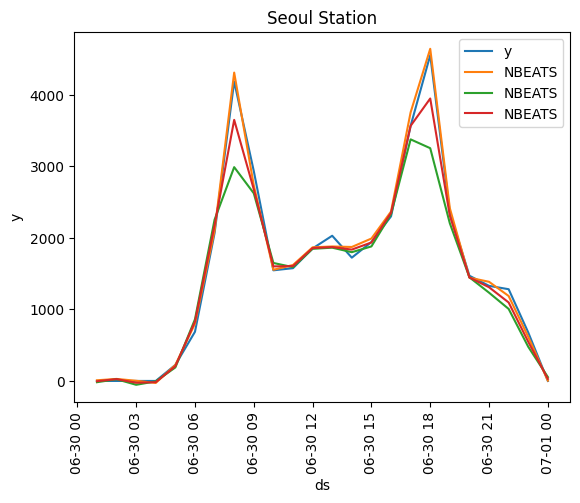

In [19]:
import numpy as np
import pandas as pd
from IPython.display import display, Markdown

from sklearn.metrics import mean_absolute_percentage_error as mape


import matplotlib.pyplot as plt
from neuralforecast import NeuralForecast
from neuralforecast.models import NBEATS, NHITS,
from neuralforecast.utils import AirPassengersDF

# Split data and declare panel dataset
# Y_df = AirPassengersDF
# Y_train_df = Y_df[Y_df.ds<='1959-12-31'] # 132 train
# Y_test_df = Y_df[Y_df.ds>'1959-12-31'] # 12 test

# Fit and predict with NBEATS and NHITS models
horizon = len(test)
# models = [NBEATS(input_size=7 * horizon, h=horizon, max_steps=100),
#           NHITS(input_size=7 * horizon, h=horizon, max_steps=50),
#           AutoLSTM(h=12, config=config, num_samples=1, cpus=1)]
models = AutoLSTM(h=12, config=config, num_samples=1, cpus=1)
nf = NeuralForecast(models=models, freq='H')
nf.fit(df=train)
Y_hat_df = nf.predict().reset_index()

# Plot predictions
# fig, ax = plt.subplots(1, 1, figsize = (20, 7))
# Y_hat_df = test.merge(Y_hat_df, how='left', on=['unique_id', 'ds'])
# plot_df = pd.concat([train, Y_hat_df]).set_index('ds')

# plot_df[['y', 'NBEATS', 'NHITS']].plot(ax=ax, linewidth=2)

# ax.set_title('AirPassengers Forecast', fontsize=22)
# ax.set_ylabel('Monthly Passengers', fontsize=20)
# ax.set_xlabel('Timestamp [t]', fontsize=20)
# ax.legend(prop={'size': 15})
# ax.grid()
Y_hat_df
Y_hat_df['mean'] = (Y_hat_df['NBEATS'] + Y_hat_df['NHITS']) / 2

to_plot = Y_hat_df.merge(test, on='ds', how='left')

fig, ax = plt.subplots()
sns.lineplot(to_plot, x='ds', y='y', ax=ax, label='y')
sns.lineplot(to_plot, x='ds', y='NBEATS', ax=ax, label='NBEATS')
sns.lineplot(to_plot, x='ds', y='NHITS', ax=ax, label='NBEATS')
sns.lineplot(to_plot, x='ds', y='mean', ax=ax, label='NBEATS')

plt.title('Seoul Station')
plt.legend()
plt.xticks(rotation=90)

print(mape(Y_hat_df['NBEATS'].values, test.head(24)['y'].values))
print(mape(Y_hat_df['NHITS'].values, test.head(24)['y'].values))
print(mape(Y_hat_df['mean'].values, test.head(24)['y'].values))


In [20]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from neuralforecast.tsdataset import TimeSeriesDataset
from neuralforecast.utils import AirPassengersDF as Y_df


In [21]:
Y_train_df = Y_df[Y_df.ds<='1959-12-31'] # 132 train
Y_test_df = Y_df[Y_df.ds>'1959-12-31']   # 12 test
dataset, *_ = TimeSeriesDataset.from_df(Y_train_df)


In [22]:
config = dict(max_steps=2, val_check_steps=1, input_size=-1, encoder_hidden_size=8)
model = AutoLSTM(h=12, config=config, num_samples=1, cpus=1)

# Fit and predict
model.fit(dataset=dataset)
y_hat = model.predict(dataset=dataset)

# Optuna
model = AutoLSTM(h=12, config=None, backend='optuna')
assert model.config(MockTrial())['h'] == 12


NameError: name 'AutoLSTM' is not defined

In [4]:
AirPassengersDF


,unique_id,ds,y
0,1.0,1949-01-31,112.0
1,1.0,1949-02-28,118.0
2,1.0,1949-03-31,132.0
3,1.0,1949-04-30,129.0
4,1.0,1949-05-31,121.0
...,...,...,...
139,1.0,1960-08-31,606.0
140,1.0,1960-09-30,508.0
141,1.0,1960-10-31,461.0
142,1.0,1960-11-30,390.0
